In [1]:
%load_ext line_profiler

from sys import argv
from copy import deepcopy
from itertools import product
import itertools

import pandas as pd
import numpy as np
import scipy as sp
import scipy.constants as spconst
from scipy.integrate import quad
from scipy.integrate import trapz
from matplotlib import pyplot as plt

from ipywidgets import interact, widgets

np.set_printoptions(precision=2)
DIPOLES_FILE = "globus\\GW_transition_dipole_files\\GW_transition_dipoles.csv"

In [2]:
df = pd.read_csv(DIPOLES_FILE, index_col=0)
mu_df2 = pd.read_csv(DIPOLES_FILE, index_col=[1,4,5,6,7,8,9])
df = df.fillna(0)
df = df.drop(columns=["mu_sym","mu_spin"])
df['B_spin'] = df['B_spin'].astype(int)
df['C_spin'] = df['C_spin'].astype(int)

benergy_df = df.drop(columns=["mu_label", "C_energy", "C_state_no", "C_sym", "C_spin", "moment"])
benergy_df = benergy_df.drop_duplicates()
benergy_df = benergy_df.rename(columns={"B_state_no": "state_no", "B_sym": "sym", "B_spin": "spin", "B_energy": "energy"})

cenergy_df = df.drop(columns=["mu_label", "B_energy", "B_state_no", "B_sym", "B_spin", "moment"])
cenergy_df = cenergy_df.drop_duplicates()
cenergy_df = cenergy_df.rename(columns={"C_state_no": "state_no", "C_sym": "sym", "C_spin": "spin", "C_energy": "energy"})

energy_df = pd.concat([benergy_df, cenergy_df])
energy_df = energy_df.drop_duplicates(subset=["state_no", "sym", "spin"])
energy_df = energy_df.sort_values("energy")
energy_df = energy_df.set_index(["state_no", "sym", "spin"])
display(energy_df)
state_order = energy_df.index.to_list()
display(state_order)

rho_populations = list(zip(state_order, state_order))
rho_coherences = [ (state1, state2) for state1, state2 in product(state_order, state_order)
                  if (state1, state2) not in rho_populations]
rho_ordered = rho_populations + rho_coherences

mu_df = df.drop(columns=["B_energy", "C_energy"])
mu_df_adj = mu_df.rename(columns={"C_state_no": "B_state_no", "C_sym": "B_sym",
                                  "C_spin": "B_spin", "B_state_no": "C_state_no",
                                  "B_sym": "C_sym", "B_spin": "C_spin"})

mu_df = pd.concat([mu_df, mu_df_adj])
mu_df = mu_df.drop_duplicates(subset=["mu_label", "B_state_no", "B_sym", "B_spin", "C_state_no", "C_sym", "C_spin"])
mu_df = mu_df.set_index(["mu_label", "B_state_no", "B_sym", "B_spin", "C_state_no", "C_sym", "C_spin"]).sort_index()
display(mu_df.loc[('z', 0, 1, 0, 0, 1, 0)])


energy
state_no sym spin          
0        1   0     0.000000
1        1   0     0.150763
         4   0     0.152166
         2   0     0.159919
         3   0     0.163620
2        2   0     0.167713
3        2   0     0.172648
2        1   0     0.196199
3        1   0     0.236141
2        4   0     0.287637
         3   0     0.290678
3        3   0     0.308605
         4   0     0.317828

[(0, 1, 0),
 (1, 1, 0),
 (1, 4, 0),
 (1, 2, 0),
 (1, 3, 0),
 (2, 2, 0),
 (3, 2, 0),
 (2, 1, 0),
 (3, 1, 0),
 (2, 4, 0),
 (2, 3, 0),
 (3, 3, 0),
 (3, 4, 0)]

C:\Users\Main\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



moment   -1.669993
Name: (z, 0, 1, 0, 0, 1, 0), dtype: float64

In [3]:
27.2114*energy_df

energy
state_no sym spin          
0        1   0     0.000000
1        1   0     4.102478
         4   0     4.140640
         2   0     4.351612
         3   0     4.452316
2        2   0     4.563719
3        2   0     4.697990
2        1   0     5.338850
3        1   0     6.425720
2        4   0     7.827002
         3   0     7.909755
3        3   0     8.397570
         4   0     8.648555

# Functions for converting a dataframe to matrix in Hilbert or Liouville Space

In [4]:
def delta(state1, state2):
    if all([elm1 == elm2 for elm1, elm2 in zip(state1, state2)]):
        return 1
    else:
        return 0

def mu_liouville_element(mu_df, mu_label, rho_1, rho_2):
    n_prime, m_prime = rho_1
    n, m = rho_2
    try:
        mu_nnp = mu_df.loc[(mu_label, *n, *n_prime)].to_numpy()[0]
    except KeyError as e:
        mu_nnp = 0
    try:
        mu_mmp = mu_df.loc[(mu_label, *m_prime, *m)].to_numpy()[0]
    except KeyError as e:
        mu_mmp = 0
    
    return mu_nnp*delta(m, m_prime) - mu_mmp*delta(n, n_prime)

def make_mu_liouville_matrix(mu_df, rho_ordered):
    mus = {}
    for mu_label in ["x", "y", "z"]:
        mus[mu_label] = np.zeros(2*[len(rho_ordered)])
        for i, rho1 in enumerate(rho_ordered):
            for j, rho2 in enumerate(rho_ordered):
                mus[mu_label][i, j] = mu_liouville_element(mu_df, mu_label, rho1, rho2)
                                   
    return mus

def make_L_mol_liouville_matrix(energy_df, rho_ordered):
    L_mol = np.diag([energy_df.loc[rho[0]].to_numpy()[0] - energy_df.loc[rho[1]].to_numpy()[0] 
                                   for rho in rho_ordered])
    return L_mol


In [5]:
def mu_element(mu_df, mu_label, rho):
    n, m = rho
    try:
        mu_elm = mu_df.loc[(mu_label, *n, *m)].to_numpy()[0]
    except KeyError as e:
        mu_elm = 0
    
    return mu_elm

def make_mu_matrix(mu_df, state_order):
    mus = []
    for mu_label in ["x", "y", "z"]:
        mus.append(np.array([[mu_element(mu_df, mu_label, (elm1, elm2))
                                   for elm1 in state_order] for elm2 in state_order]))
    return np.array(mus)

def make_H_mol_matrix(energy_df, state_order):
    H_mol = np.zeros(2*[len(state_order)])
    for i, s1 in enumerate(state_order):
        H_mol[i,i] = energy_df.loc[s1].to_numpy()[0]
    return H_mol

# Functions to convert a Hilbert Space representation to Liouville and back

In [6]:
def hilbert_to_liouville_vector(hilbert_matrix):
    order_states = list(range(0, hilbert_matrix.shape[0]))
    order_pops = list(zip(order_states, order_states))
    order_cohrs = [(state1, state2) for state1, state2 in product(order_states, order_states)
                  if (state1, state2) not in order_pops]
    order = order_pops + order_cohrs
    
    liouville_vector = np.array([hilbert_matrix[i, j] for i,j in order])
    return liouville_vector

def liouville_vec_to_hilbert_matrix(liouville_vector):
    no_states = int(np.sqrt(len(liouville_vector)))
    order_states = list(range(0, no_states))
    order_pops = list(zip(order_states, order_states))
    order_cohrs = [(state1, state2) for state1, state2 in product(order_states, order_states)
                  if (state1, state2) not in order_pops]
    order = order_pops + order_cohrs
    
    hilbert_matrix = np.zeros(2*[no_states])
    for index, indices in enumerate(order):
        hilbert_matrix[indices[0], indices[1]] = liouville_vector[index]
    return hilbert_matrix

def hilbert_to_liouville_matrix(hilbert_matrix):
    no_states = hilbert_matrix.shape[0]
    order_states = list(range(0, no_states))
    order_pops = list(zip(order_states, order_states))
    order_cohrs = [(state1, state2) for state1, state2 in product(order_states, order_states)
                  if (state1, state2) not in order_pops]
    order = order_pops + order_cohrs
    
    liouville_matrix = np.zeros(2*[len(order)])
    for index, ipair in enumerate(order):
        irho_matrix = np.zeros(2*[no_states])
        irho_matrix[ipair[0], ipair[1]] = 1
        for jndex, jpair in enumerate(order):
            jrho_matrix = np.zeros(2*[no_states])
            jrho_matrix[jpair[0], jpair[1]] = 1
            
            com = hilbert_matrix @ irho_matrix - irho_matrix @ hilbert_matrix
            liouville_matrix[index, jndex] = np.trace(jrho_matrix.T @ com)
    return liouville_matrix


# Functions to compute an estimate of the Decay matrix and the zeroth order time evolution operator in liouville space 

In [7]:
# guess for the Decay matrix in Liouville Space
def make_guess_from_energy(H_mol):
    no_states = H_mol.shape[0]
    order_states = list(range(0, no_states))
    order_pops = list(zip(order_states, order_states))
    order_cohrs = [(state1, state2) for state1, state2 in product(order_states, order_states)
                  if (state1, state2) not in order_pops]
    
    liouville_matrix = np.zeros(2*[len(order_pops + order_cohrs)])
    for index, ipair in enumerate(order_pops):
        for jndex, jpair in enumerate(order_pops):
            if index > jndex:
                liouville_matrix[jndex, index] = abs(H_mol[ipair] - H_mol[jpair])/100
    
    for jndex, jpair in enumerate(order_pops):
        liouville_matrix[jndex, jndex] = -sum(liouville_matrix[:jndex, jndex])
    
    offset = len(order_pops)
    for index, ipair in enumerate(order_cohrs):
        num = abs(H_mol[ipair[0], ipair[0]] - H_mol[ipair[1], ipair[1]])/100
        liouville_matrix[index + offset, index + offset] = num
    
    return liouville_matrix
    

In [8]:
def liou_time_op(L_0, t, t0):
    return sp.linalg.expm(-1j*L_0*(t - t0))

def liou_inverse(U_0):
    return np.linalg.inv(U_0)

In [9]:
np.array([np.cos(1)**2, np.sin(1)**2, 0])

array([0.29, 0.71, 0.  ])

# Functions that estimate input gaussian efields

In [10]:
#atomic units
c = spconst.physical_constants["inverse fine-structure constant"][0]
amp, sigma, freq, k = 1*10**-6, 10**3, 1*10**-2, 0.0608/c
decay = 1/sigma**2
spec_amp, chirp = 1, 3
t0, z0 = 0, 0

def gaussian_pulse(z, t, z0, t0, amp, decay, freq, k):
    Z = z - z0
    T = t - t0
    return np.real(amp*np.exp(-decay*(Z/c-T)**2)*np.exp(-1j*freq*T-1j*k*Z))

def gaussian_Efield_z_prop(z, t, z0, t0, amp, decay, freq, k, theta):
    amp = gaussian_pulse(z, t, z0, t0, amp, decay, freq, k)
    x = amp*np.cos(theta)
    y = amp*np.sin(theta)
    z = 0
    return np.array([x, y, z])

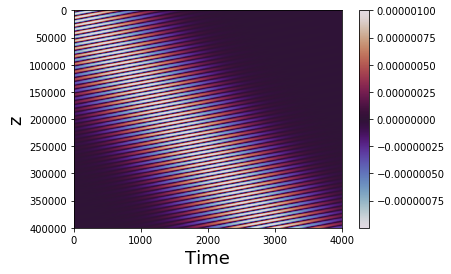

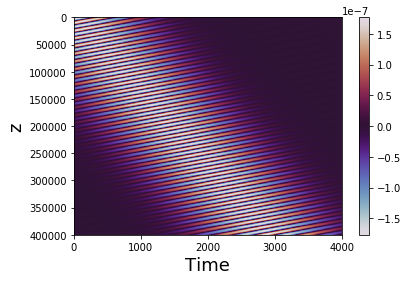

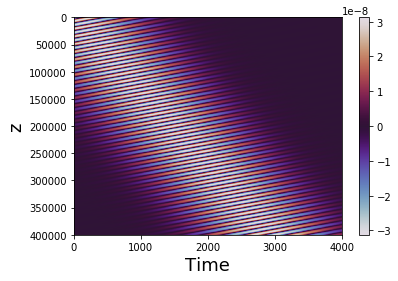

In [11]:
t = np.linspace(0, 4000.1, 1000)
z = np.linspace(0, 400000.1, 1000)
T, Z = np.meshgrid(t, z)

A = gaussian_pulse(Z, T, z0, t0, amp, decay, freq, k)
dA = np.gradient(A, axis=0)
ddA = np.gradient(dA, axis=0)

cmap="twilight"

plt.imshow(A, cmap=cmap, extent=[t.min(), t.max(), z.max(), z.min()], aspect="auto")
plt.xlabel("Time", size=18)
plt.ylabel("z", size=18)
plt.colorbar()
plt.show()

plt.imshow(dA, cmap=cmap, extent=[t.min(), t.max(), z.max(), z.min()], aspect="auto")
plt.xlabel("Time", size=18)
plt.ylabel("z", size=18)
plt.colorbar()
plt.show()

plt.imshow(ddA, cmap=cmap, extent=[t.min(), t.max(), z.max(), z.min()], aspect="auto")
plt.xlabel("Time", size=18)
plt.ylabel("z", size=18)
plt.colorbar()
plt.show()

# Functions to compute the lab frame response from molecular frame

In [12]:
def rot_ave_gamma_element(gamma, i, j, k, l):
    """
    Calculated the pure electronic rotationally averaged second hyperpolarizability in
    the lab frame using the molecular frame second order hyperpolarizability
    
    i,j,k,l are the lab frame cartiesian indices of rotationally ave gamma
    gamma is a 4th rank tensor with 4 indices in the molecular frame 
    
    Kwak 2015 Rigorous theory of molecular orientational nonlinear optics A7
    """

    def delta(i, j):
        """
        Python implementation of a delta function
        """
        if i == j:
            return 1
        else:
            return 0

    coordinates = [0, 1, 2]
    
    #Calculate pure electronic case
    del_fact0 = 4*delta(i, j)*delta(k, l) - delta(i, k)*delta(j, l) - delta(i, l)*delta(j, k)
    del_fact1 = 4*delta(i, k)*delta(j, l) - delta(i, j)*delta(k, l) - delta(i, l)*delta(j, k)
    del_fact2 = 4*delta(i, l)*delta(j, k) - delta(i, k)*delta(j, l) - delta(i, j)*delta(k, l)
    
    accumulator = 0
    called_indices = []
    for J in coordinates:
        for K in coordinates:
            accumulator += del_fact0*gamma[J,J,K,K] + del_fact1*gamma[J,K,J,K] + del_fact2*gamma[J,K,K,J]
            called_indices.append((J,J,K,K))
            called_indices.append((J,K,J,K))
            called_indices.append((J,K,K,J))
    accumulator /= 30
    return accumulator

def rot_ave_gamma(gamma):
    temp_gamma = np.zeros(gamma.shape, dtype=np.complex)
    
    coordinates = [0, 1, 2]
    for i,j,k,l in itertools.product([0,1,2], repeat=4):
        temp_gamma[i,j,k,l] = rot_ave_gamma_element(gamma, i, j, k, l)
    return temp_gamma
        
def rot_ave_UR_3_element(UR_3, j, k, l):
    """
    Calculates the rotationally averaged perturbed 3rd order time evolution response function.
    Which is used to calculate 3rd order time evolution operator and gamma
    """
    raise NotImplementedError

In [13]:
np.imag(1j)

1.0

# Functions to compute the nth order Liouville Space time evolution operator

In [14]:

a = np.ones([2,3,4])
b = np.ones([5,4,8])
V = np.ones([2,3,4])
U = np.ones([4,5])
Uinv = np.ones([6,3])

def tdot1(a, b):
    temp = np.tensordot(a, b, axes=[[-1], [1]])
    temp = np.swapaxes(temp, -3, -2)
    return temp

def tdot2(V, U):
    temp = np.tensordot(V, U, axes=[[-1], [0]])
    return temp

def tdot3(Uinv, V):
    temp = np.tensordot(V, Uinv, axes=[[-2], [1]])
    return temp

def U0_liou(L_0, t, t0):
    return sp.linalg.expm(-1j*L_0*(t - t0))

def U0_and_inv_liou(L_0, t, t0):
    temp = sp.linalg.expm(-1j*L_0*(t - t0))
    return temp, np.linalg.inv(temp)
    """
    except Exception as e:
        print("t, t0 = ", t, t0)
        U0_bound = max([abs(np.min(np.real(temp))), abs(np.max(np.real(temp)))])
        plt.imshow(np.real(temp), cmap='twilight', vmin=-U0_bound, vmax=U0_bound)
        plt.title("$Real \mathcal{U}_{0}$", fontsize=22)
        plt.colorbar()
        plt.show()
        
        U0_bound = max([abs(np.min(np.imag(temp))), abs(np.max(np.imag(temp)))])
        plt.imshow(np.imag(temp), cmap='twilight', vmin=-U0_bound, vmax=U0_bound)
        plt.title("$Imag \mathcal{U}_{0}$", fontsize=22)
        plt.colorbar()
        plt.show()
        raise e
        """

def perturbed_time_evo_resp_liou_gen(mu_liou_xyz, L_0, order=3):
    assert(order >= 1)
    def perturbed_liou_time_evo(*args):
        """
        parameters:
            t0, tau1, tau2, ..., tau_order, t_final
        """
        i = 0
        t0 = args[i]
        i += 1
        tau_next = args[i]
        i += 1
        
        U0, U0_inv = U0_and_inv_liou(L_0, tau_next, t0)
        temp = tdot3(U0_inv, tdot2(mu_liou_xyz, U0))
        
        for _ in range(order-1):
            tau_next = args[i]
            i += 1
            U0, U0_inv = U0_and_inv_liou(L_0, tau_next, t0)
            temp_next = tdot3(U0_inv, tdot2(mu_liou_xyz, U0))
            temp = tdot1(temp, temp_next)
        
        t_final = args[i]
        U0 = U0_liou(L_0, t_final, t0)
        temp = tdot3(U0, temp)
        return temp*1j**order
    return perturbed_liou_time_evo
    
#expected output (2, 5, 3, 8), (2, 3, 5), (2, 5, 6)
print(tdot1(a, b).shape)
print(tdot2(V, U).shape)
print(tdot3( Uinv, tdot2(V, U)).shape)



(2, 5, 3, 8)
(2, 3, 5)
(2, 5, 6)


# Functions to compute the time ordered integrals

In [15]:
def complex_quad(func, a, b, **kwargs):
    def real_func(*args):
        return sp.real(func(*args))
    def imag_func(*args):
        return sp.imag(func(*args))
    real_integral = quad(real_func, a, b, **kwargs)
    imag_integral = quad(imag_func, a, b, **kwargs)
    return (real_integral[0] + 1j*imag_integral[0], real_integral[1:], imag_integral[1:])

counter = 0
def time_ordered(t_f, t_0, function, current_depth=0, max_depth=3, params=None):
    global counter
    if current_depth == 0:
        params = [t0, t_f]
    else:
        params = deepcopy(params)
        params.insert(-1, t_f)
    if current_depth >= max_depth:
        counter += 1
        return function(*params)
    args = (t_0, function, current_depth + 1, max_depth, params)
    return complex_quad(time_ordered, t_0, t_f, args=args)[0] 

In [16]:
counter = 0
limits = [1, 0]

f_temp = lambda x0, x1, x2, x3, xf: 1 
print("test of time_ordered integral with constant function\nvalue = ", time_ordered(limits[0], limits[1], f_temp))
print("expected =", 1/6, "\ncounter =", counter)
f_temp = lambda x0, x1, x2, x3, xf: x0 + x1 + x2 + x3 + xf
counter = 0
print("\ntest of time_ordered integral with linear function\nvalue = ", time_ordered(limits[0], limits[1], f_temp))
print("counter =", counter)
f_temp = lambda x0, x1, x2, x3, xf: x0 + x1*x2*x3*xf
counter = 0
print("\ntest of time_ordered integral with product function\nvalue = ", time_ordered(limits[0], limits[1], f_temp))
print("counter =", counter)

test of time_ordered integral with constant function
value =  (0.16666666666666669+0j)
expected = 0.16666666666666666 
counter = 74088

test of time_ordered integral with linear function
value =  (0.4166666666666667+0j)
counter = 74088

test of time_ordered integral with product function
value =  (0.020833333333333336+0j)
counter = 74088


In [17]:
f_temp = lambda x0, x1, x2, x3, xf: 1 
%timeit f_temp(0, .3, .2, .1, .4)

263 ns ± 11.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


# Actual computation

In [18]:
# slow
#mu_liou_xyz = make_mu_liouville_matrix(mu_df, rho_ordered)
#mu_liou_xyz['x'].shape

# slow
#L_mol = make_L_mol_liouville_matrix(energy_df, rho_ordered)
#L_mol.shape

In [19]:
mu_xyz = make_mu_matrix(mu_df, state_order)
print(mu_xyz.shape)

mu_vec_xyz = []
for index in range(3):
    mu_vec_xyz.append(hilbert_to_liouville_vector(mu_xyz[index]))
mu_vec_xyz = np.array(mu_vec_xyz)
print(mu_vec_xyz.shape)

(3, 13, 13)
(3, 169)


In [20]:
mu_liou_xyz = []
for index in range(3):
    mu_liou_xyz.append(hilbert_to_liouville_matrix(mu_xyz[index, :, :]))
mu_liou_xyz = np.array(mu_liou_xyz)
print(mu_liou_xyz.shape)

(3, 169, 169)


In [21]:
H_mol = make_H_mol_matrix(energy_df, state_order)

L_mol = hilbert_to_liouville_matrix(H_mol)
L_mol.shape

(169, 169)

In [22]:
#estimate of the decay operator and zeroth order Liouville
Decay = make_guess_from_energy(H_mol)

L_0 = L_mol + 1j*Decay

In [23]:
#estimate of rho at t0
rho_t0 = np.zeros(2*[len(state_order)])
rho_t0[0,0] = 1
rho_t0_vec = hilbert_to_liouville_vector(rho_t0)

In [24]:
#computing the time evolution operator and gamma
UR_3 = perturbed_time_evo_resp_liou_gen(mu_liou_xyz, L_0, order=3)

def gamma_R_3(ti, t0, t1, t2, tf):
    temp = np.tensordot(mu_vec_xyz, UR_3(ti, t0, t1, t2, tf), axes=[[1], [-2]])
    temp = np.tensordot(temp, rho_t0_vec, axes=[[-1], [0]])
    return temp

def rot_ave_gamma_R_3(ti, t0, t1, t2, tf):
    return rot_ave_gamma(gamma_R_3(ti, t0, t1, t2, tf))

temp = UR_3(0, .3, .2, .1, .4)
print(temp.shape)

temp = gamma_R_3(0, .3, .2, .1, .4)
print(temp.shape)

temp = rot_ave_gamma_R_3(0, .3, .2, .1, .4)
print(temp.shape)

#%timeit rot_ave_gamma_R_3(0, .3, .2, .1, .4)

#%timeit UR_3(0, .3, .2, .1, .4)

(3, 3, 3, 169, 169)
(3, 3, 3, 3)
(3, 3, 3, 3)


In [28]:
%lprun -f UR_3 UR_3(0, .3, .2, .1, .4)

In [59]:
Eprobe = lambda t, tau, z: gaussian_Efield_z_prop(z, t, 0, tau, amp, decay, freq, k, 0)

Edrive = lambda t, z: gaussian_Efield_z_prop(z, t, 0, 0, amp, decay, freq, k, np.pi/4)

E_pulses = lambda t, tau, z: Eprobe(t, tau, z) + Edrive(t, z)

def tdot_fields(U, v):
    temp = np.tensordot(U, v, axes=[[-1], [0]])
    return temp

def integrand(ti, t0, t1, t2, tf, tau, z):
    return 1
    temp = tdot_fields(rot_ave_gamma_R_3(ti, t0, t1, t2, tf), E_pulses(t2 - ti, tau, z))
    temp = tdot_fields(temp, E_pulses(t1 - ti, tau, z))
    temp = tdot_fields(temp, E_pulses(t0 - ti, tau, z))
    temp = tdot_fields(temp, np.array([0,1,0]))
    return temp

def YPolarization_lab(t_final, t_init, tau, z, no_time_steps):
    ts = np.linspace(t_init, t_final, no_time_steps)

    integrand_arr = np.zeros(3*[len(ts)], dtype=np.complex)
    integrand_arr.shape
    indicies = list(range(len(ts)))
    for i0, i1, i2 in itertools.product(indicies, repeat=3):
        t0, t1, t2 = ts[i0], ts[i1], ts[i2]
        if t_final >= t0 >= t1 >= t2:
            integrand_arr[i0, i1, i2] = integrand(t_init, t0, t1, t2, t_final, tau, z)
    return trapz(trapz(trapz(integrand_arr, ts), ts), ts)

def Vy_lab(t_init, t_final, t0, tau, z_init, z_final, k, no_t_steps, no_z_steps, no_integral_steps):
    ts = np.linspace(t_init, t_final, no_t_steps)
    dt = ts[0] - ts[1]
    zs = np.linspace(z_init, z_final, no_z_steps)
    Ts, Zs = np.meshgrid([ts, zs])
    
    yPol_arr = np.zeros([no_t_steps, no_z_steps], dtype=np.complex)
    for t, it in enumerate(ts):
        for z, iz in enumerate(zs):
            yPol_arr[it, iz] = YPolarization_lab(t, t0, tau, z, no_integral_steps)
    
    ddt_Py = np.gradient(yPol_arr, varargs=[dt], axis=0)
    Ey = 1j*trapz(ddt_Py*np.exp(1j*k*Zs), zs, axis=1)
    return abs(Ey)**2

#with open("convergence.csv", 'a') as f:
#    #f.write("Time_Steps,squared_error,Real,Imag\n")
#    for n in range(200,1000,21):
#        val = YPolarization_lab(1, 0, 0, 0, n)
#        print("Time Ordered Integral = ", val, " time_steps = ", n, "integrand = 1")
#        f.write(f"{n},{(val.real-1/6)**2},{val.real},{val.imag}\n")

Time Ordered Integral =  (0.16918130208122506+0j)  time_steps =  200 integrand = 1
Time Ordered Integral =  (0.1689410922238918+0j)  time_steps =  221 integrand = 1
Time Ordered Integral =  (0.16874277238090946+0j)  time_steps =  242 integrand = 1
Time Ordered Integral =  (0.16857626370551726+0j)  time_steps =  263 integrand = 1
Time Ordered Integral =  (0.16843448059793198+0j)  time_steps =  284 integrand = 1
Time Ordered Integral =  (0.1683122963299816+0j)  time_steps =  305 integrand = 1
Time Ordered Integral =  (0.16820590987710515+0j)  time_steps =  326 integrand = 1
Time Ordered Integral =  (0.16811244342825224+0j)  time_steps =  347 integrand = 1
Time Ordered Integral =  (0.16802967813853462+0j)  time_steps =  368 integrand = 1
Time Ordered Integral =  (0.167955875728492+0j)  time_steps =  389 integrand = 1
Time Ordered Integral =  (0.16788965506395262+0j)  time_steps =  410 integrand = 1
Time Ordered Integral =  (0.16782990491403274+0j)  time_steps =  431 integrand = 1
Time Ord

KeyboardInterrupt: 

In [ ]:
%timeit x = integrand(0, .3, .2, .1, .4, 2, 0)
#%timeit x = integrand(0, .3, .2, .1, .4, 2, 0)
#%timeit x = integrand(0, .3, .2, .1, .4, 2, 0)

In [ ]:
t_init = 0
t_final = 1
tau = 0.1
z = -0.1

%timeit YPolarization_lab(1, 0, 0, 0, 3)

%timeit YPolarization_lab(1, 0, 0, 0, 5)

#%timeit YPolarization_lab(1, 0, 0, 0, 7)

#%timeit YPolarization_lab(1, 0, 0, 0, 9)

#%timeit YPolarization_lab(1, 0, 0, 0, 11)

In [ ]:
#%timeit YPolarization_lab(1, 0, 0, 0, 13)

#%timeit YPolarization_lab(1, 0, 0, 0, 15)

#%timeit YPolarization_lab(1, 0, 0, 0, 17)

In [ ]:
"""
y = np.array([7.35, 25.8, 60, 120, 193, 305, 454, 684])
x = np.array([3, 5, 7, 9, 11, 13, 15, 17])
for i in range(6):
    def phi(x):
        return np.array([x**i for i in range(i + 1)]).T

    X = phi(x)
    w = np.linalg.inv(X.T @ X) @ X.T @ y
    train_error = ((y - X @ w).T @ (y - X @ w))/len(y)
    print("polynomial degree = ", i)
    print(f"train_error = {train_error}")
    print(f"w = {w}\n")
    
def phi(x):
    return np.array([x**i for i in range(3 + 1)]).T

X = phi(x)
w = np.linalg.inv(X.T @ X) @ X.T @ y
train_error = ((y - X @ w).T @ (y - X @ w))/len(y)
points = 100
print("\npolynomial degree = ", 3)
print(f"est_time({points} points) = {(phi(points) @ w)/(60**2)} hours")
"""

# Testing

In [29]:
def make_rhos(no_states):
    order = list(range(0, no_states))
    rho_pops = list(zip(order, order))
    rho_cohrs = [(state1, state2) for state1, state2 in product(order, order)
                  if (state1, state2) not in rho_pops]
    pairs_for_rho = rho_pops + rho_cohrs  

    for index, ipair in enumerate(pairs_for_rho):
        irho_matrix = np.zeros(2*[no_states])
        irho_matrix[ipair[0], ipair[1]] = 1
        irho_vector = np.zeros(no_states**2)
        irho_vector[index] = 1
        set1 = (irho_matrix, irho_vector, index, ipair)
        for jndex, jpair in enumerate(pairs_for_rho):
            jrho_matrix = np.zeros(2*[no_states])
            jrho_matrix[jpair[0], jpair[1]] = 1
            jrho_vector = np.zeros(no_states**2)
            jrho_vector[jndex] = 1
            set2 = (jrho_matrix, jrho_vector, jndex, jpair)
            yield set1, set2
        
def test_equivalency(hilbert_matrix, louiville_matrix, no_states):
    for set1, set2 in make_rhos(no_states):
        irho_matrix, irho_vector, index, ipair = set1
        jrho_matrix, jrho_vector, jndex, jpair = set2
        liouville_value = jrho_vector.T @ louiville_matrix @ irho_vector
        com = hilbert_matrix @ irho_matrix - irho_matrix @ hilbert_matrix
        hilbert_value = np.trace(jrho_matrix.T @ com)
        try:
            assert(np.isclose(liouville_value, hilbert_value))
        except AssertionError as e:
            print(f"L[{jndex}, {index}] = {louiville_value}, H[{jpair}, {ipair}]] = {hilbert_value}")
            #print(rho_matrix)
            #print(rho_vector)

def test_liouville_vec_to_hilbert_matrix(hilbert_matrix):
    test_matrix = liouville_vec_to_hilbert_matrix(hilbert_to_liouville_vector(hilbert_matrix))
    assert(np.all(np.isclose(test_matrix, hilbert_matrix)))
    
for axis in range(3):
    print("testing Liouvillie vectors axis - ", axis)
    test_liouville_vec_to_hilbert_matrix(mu_xyz[axis, :, :])
    print("testing Liouvillie Matricies axis - ", axis)
    test_equivalency(mu_xyz[axis, :, :], mu_liou_xyz[axis, :, :], len(state_order))
    

testing Liouvillie vectors axis -  0
testing Liouvillie Matricies axis -  0
testing Liouvillie vectors axis -  1
testing Liouvillie Matricies axis -  1
testing Liouvillie vectors axis -  2
testing Liouvillie Matricies axis -  2


In [30]:
display(mu_df.loc[('z', 2, 2, 0, 2, 2, 0)])
rho = ((2, 2, 0), (2, 2, 0))
mu_liouville_element(mu_df, 'x', rho, rho)

moment   -1.367539
Name: (z, 2, 2, 0, 2, 2, 0), dtype: float64

0

# Displaying Matricies

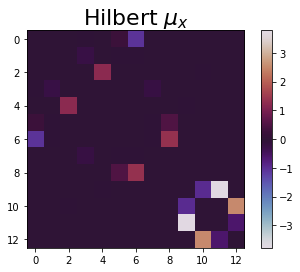

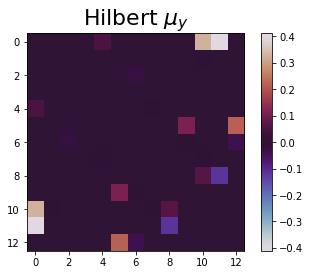

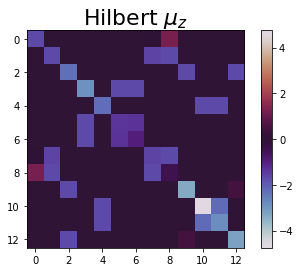

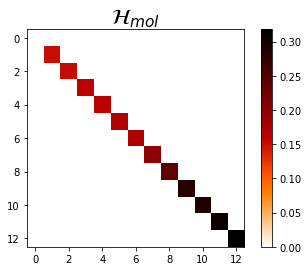

In [31]:
#Hilbert Space plots

for axis, label in enumerate(["x", "y", "z"]):
    mu = mu_xyz[axis, :, :]
    mu_bound = max([abs(np.min(mu)), abs(np.max(mu))])
    plt.imshow(mu, cmap='twilight', vmin=-mu_bound, vmax=mu_bound)
    plt.title("Hilbert $\mu_" + label + "$", fontsize=22)
    plt.colorbar()
    plt.show()
    
#H_mol_bound = max([abs(np.min(H_mol)), abs(np.max(H_mol))])
plt.imshow(H_mol, cmap='gist_heat_r')#, vmin=-mu_bound, vmax=mu_bound)
plt.title("$\mathcal{H}_{mol}$", fontsize=22)
plt.colorbar()
plt.show()

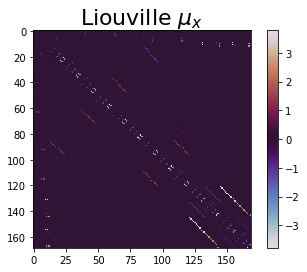

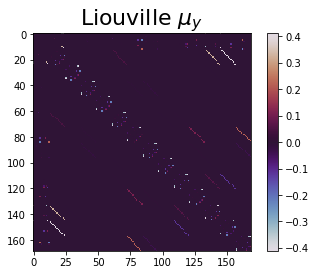

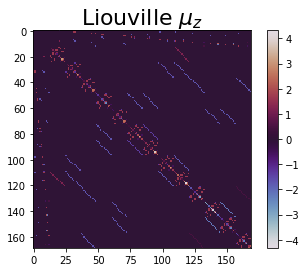

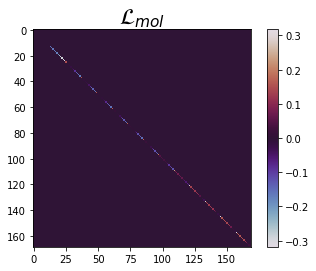

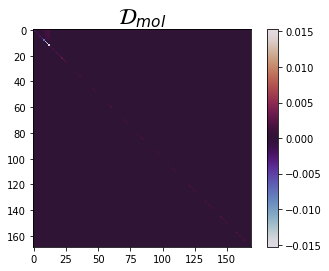

In [32]:
#Liouville Space plots

for axis, label in enumerate(["x", "y", "z"]):
    mu = mu_liou_xyz[axis, :, :]
    mu_bound = max([abs(np.min(mu)), abs(np.max(mu))])
    plt.imshow(mu, cmap='twilight', vmin=-mu_bound, vmax=mu_bound)
    plt.title("Liouville $\mu_" + label + "$", fontsize=22)
    plt.colorbar()
    plt.show()
    

L_mol_bound = max([abs(np.min(L_mol)), abs(np.max(L_mol))])
plt.imshow(L_mol, cmap='twilight', vmin=-L_mol_bound, vmax=L_mol_bound)
plt.title("$\mathcal{L}_{mol}$", fontsize=22)
plt.colorbar()
plt.show()

Decay_bound = max([abs(np.min(Decay)), abs(np.max(Decay))])
plt.imshow(Decay, cmap='twilight', vmin=-Decay_bound, vmax=Decay_bound)
plt.title("$\mathcal{D}_{mol}$", fontsize=22)
plt.colorbar()
plt.show()

In [33]:
def Decay_plot_zoomed(n):
    Decay_zoomed = Decay[n + 0:n + 15, n + 0:n + 15]
    Decay_bound = max([abs(np.min(Decay)), abs(np.max(Decay))])
    plt.imshow(Decay_zoomed, cmap='twilight', vmin=-Decay_bound, vmax=Decay_bound)
    plt.title("$\mathcal{D}_{mol}$", fontsize=22)
    plt.colorbar()
    plt.show()
    
interact(Decay_plot_zoomed, n=(0, Decay.shape[0]-15))

interactive(children=(IntSlider(value=77, description='n', max=154), Output()), _dom_classes=('widget-interact…

<function __main__.Decay_plot_zoomed(n)>

In [40]:
#Liouville Space sparsity

for axis, label in enumerate(["x", "y", "z"]):
    mu = mu_liou_xyz[axis, :, :]
    sparsity = (np.count_nonzero(mu)/float(mu.size))
    print(f"mu_{axis} density = {sparsity*100} %")
    

sparsity = (np.count_nonzero(L_mol)/float(L_mol.size))
print(f"mu_{axis} density = {sparsity*100} %")

sparsity = (np.count_nonzero(Decay)/float(Decay.size))
print(f"mu_{axis} density = {sparsity*100} %")

mu_0 density = 3.8233955393718713 %
mu_1 density = 3.641329085116067 %
mu_2 density = 3.2771961766044604 %
mu_2 density = 0.5461993627674101 %
mu_2 density = 0.8613143797486082 %
